# Deep Learning
These are notes from chapter 2 of Generative Deep Learning by David Foster.


## 1. What is Deep Learning?

> Deep learning is a class of ML algorithms that use *multiple stacked layers of processing units* to learn high-level representations from *unstructured* data.

Structured data is naturally arranged into columns of features. Think of relational database tables.

By contrast, *unstructured* data refers to any data that is not structured in tabular format. E.g. images, audio, text.
Individual pixels -- or frequencies or words -- are not informative alone, but higher-level representations are, so we aim to learn these.


## 2. Deep Neural Networks

Most deep learning systems in practice are ANNs,so deep learning has become synonymous with deep deural networks, vut there are other forms such as deep belief networks.

A neural network where all adjacent layers are fully connected is called a *Multilayer Perceptron (MLP)* for historical reasons.

*Batches* of inputs (e.g. images) are passed through and the predicted outputs are compared to the ground truth. This gives a *loss function*.

The prediction error is then *back propagated* through the network to adjust the weights incrementally.

This allows the model to learn features without manual feature engineering. Earlier layers learn low-level features (like edges) and these are combined in intermediate leayers to learn features like teeth, through to later layers which learning high-level representations like smiling.


## 3. Building a Multilayer Perceptron

We will implement an MLP for a supervised (read: not generative) learning problem to classify images.

The following uses the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).


### 3.1. Load and Pre-process the Data
Load the dataset, then scale pixel values to be in the 0 to 1 range and one-hot encode the labels.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, optimizers, utils, datasets


# Load the data set
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Scale pixel values to be between 0 and 1.
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

# One-hot encode the labels. The CIFAR-10 dataset contains 10 categories.
NUM_CLASSES = 10
y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_test = utils.to_categorical(y_test, NUM_CLASSES)

170498071/170498071 [==============================] - 64s 0us/step


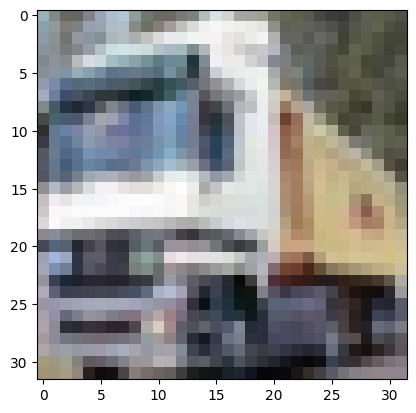

In [22]:
#| code-fold: false
plt.imshow(x_train[1])

In [23]:
#| code-fold: false
print(y_train[:5])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


### 3.2. Build the Model
The model is a series of fully connected dense layers.

In [25]:
INPUT_SHAPE = (32, 32, 3,)

input_layer = layers.Input(INPUT_SHAPE)
x = layers.Flatten()(input_layer)
x = layers.Dense(units=200, activation='relu')(x)
x = layers.Dense(units=150, activation='relu')(x)
output_layer = layers.Dense(units=10, activation='softmax')(x)

model = models.Model(input_layer, output_layer)

The nonlinear *activation function* is critical, as this ensures the model is able to learn complex functions of the input rather than simply a linear combination of inputs.

Each unit within a given layer has a bias term that alwways output 1, which ensures that the output of a unit can be non-zero even if the inputs were all 0. This helps prevent *vanishing gradients*.

The **number of parameters** in the 200-unit Dense layer is thus:
$200 * (3072 + 1) = 614600$

In [26]:
#| code-fold: false
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 200)               614600    
                                                                 
 dense_1 (Dense)             (None, 150)               30150     
                                                                 
 dense_2 (Dense)             (None, 10)                1510      
                                                                 
Total params: 646260 (2.47 MB)
Trainable params: 646260 (2.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 3.3. Train the model
To train the model, we require an *optimizer* and a *loss function*.

#### Loss Function
This is used by the network to compare predicted outputs $p_i$ with ground truth labels $y_i$.

For **regression** tasks use *mean-squared error*:
$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - p_i)^2
$$

For **classification** tasks with **exclusive** categories uses *categorical cross-entropy*:
$$
CCE = - \sum_{i=1}^{n} y_i \log(p_i)
$$

For **classification** tasks with binary one output unit or if an observation can belong to multiple classes **simultaneously** use *binary cross-entropy*:
$$
BCE = - \frac{1}{n} \sum_{i=1}^{n} (y_i \log(p_i) + (1 - y_i) \log(1 - p_i) )
$$


#### Optimizer
This is the algorithm that updates the weights of the model based on the loss function.

Adaptive Moment Estimation *(ADAM)* or Root Mean Squared Propagation *(RMSProp)* are commonly used.

The **learning rate** is the hyperparameter that is most likely to need tweaking.


#### Batch Size

This determines gow many images are shown to the model in each training step.

The larger the batch size, the more stable the gradient calculation but at the expense of a slower training step.

> It is recommend to increase the batch size as training progresses

In [32]:
# WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
# opt = optimizers.Adam(learning_rate=0.0005)
opt = optimizers.legacy.Adam(learning_rate=0.0005)

model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

In [33]:
model.fit(x_train, y_train, batch_size=32, epochs=10, shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.8519 - accuracy: 0.3320
Epoch 2/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.6692 - accuracy: 0.4044
Epoch 3/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.5840 - accuracy: 0.4360
Epoch 4/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.5353 - accuracy: 0.4532
Epoch 5/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.4925 - accuracy: 0.4711
Epoch 6/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.4675 - accuracy: 0.4764
Epoch 7/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.4386 - accuracy: 0.4878
Epoch 8/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.4146 - accuracy: 0.4971
Epoch 9/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.3917 - accuracy: 0.5055
Epoch 10/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.369

### 3.4. Evaluate the Model
Use the model to predict the classification of unseen images from the test set.

Evaluate the model loss and accuracy over the test set:

In [34]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 560us/step - loss: 1.4571 - accuracy: 0.4813


[1.4570728540420532, 0.4812999963760376]

In [35]:
# Look at the predictions and ground truth labels from the test set
CLASSES = np.array(
    [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
)

y_pred = model.predict(x_test)
y_pred_single = CLASSES[np.argmax(y_pred, axis=1)]
y_test_single = CLASSES[np.argmax(y_test, axis=1)]

313/313 [==============================] - 0s 493us/step


Plot a comparison of a random selection of test images.

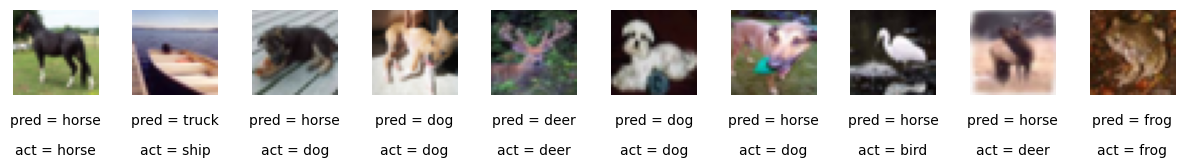

In [43]:
N_IMAGES = 10
indices = np.random.choice(range(len(x_test)), N_IMAGES)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, N_IMAGES, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + str(y_pred_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + str(y_test_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)

## 4. CNN Concepts and Layers
A simple MLP does not take into account the spatial structure of images, so we can improve performance by using  a *convolutional layer*.

This slides a *kernel* or *filter* (say, a 3x3 window) over the image and multiply the values elementwise.

A convolutional layer is a collection of kernels where the (initially random) weights are learned through training.


### 4.1. Stride
This is the step size used when moving the kernel window across the image.

This determines the output size of the layer. For example, a stride=2 layer will half the height and width of the input image.


### 4.2. Padding
When `stride=1`, we may still end up with a smaller images as the kernel does not overhang the edges of the image.

Using `padding='same'` adds 0s around the border to ensure that the output size is the same as the input size in this case (i.e. it lets the kernel overhang the edges of the original image). This helps to keep track of the size of the tensor.


### 4.3. Stacking Convolutional Layers
The output of a convolutional layer is another 4-dimensional tensor with shape `(batch_size, height, width, num_kernels)`.

So we can stack convolutional layers in series to learn higher-level representations.


### 4.4. Batch Normalization
The **exploding gradient** problem is common in deep learning: when errors are back-propagated, the gradient values in earlier layers can grow exponentially large.

In practice, this can cause overflow errors resulting in the loss function returning NaN.

The input layer is scaled, so we may naively expect the activations of all future layers to be well-scaled too. This may initially be true, but as training moves the weights further from their initial values the assumption of outputs being well-scaled breaks down. This is called **covariate shift**.

**Batch normalization** z-scores each input channel, i.e. it subtract the mean and divides by the standard deviation of each mini-batch $B$:
$$
\hat{x_i} = \frac{x_i - \mu_B}{\sqrt{\sigma_{B}^2 + \epsilon}}
$$

We then learn two parameters, scale $\gamma$ and shift $\beta$. Then the output of the `BatchNormalization` layer is:
$$
y_i = \gamma \hat{x_i} + \beta
$$

At **test time** we may predict only a single image, so the batch normalization value would not be meaningful. Instead, the `BatchNormalization` layer also stores the moving average of $\gamma$ and $\beta$ as tow additional (derived therefore non-trainable) parameters. These moving average values are used at test time.

Batch normalization has the added benefit of reducing overfitting in practice.

Usually, batch normalization layers are placed before activation layers, although this is a matter of preference. The acronym **BAD** can be helpful to remember the general order: Batchnorm, Activation, Dropout.


### 4.5. Dropout
We want to ensure that the model generalises well to unseen data, so it cannot rely on any single layer or neuron too heavily. Dropout acts as a *regularization* technique to prevent overfitting.

Each `Dropout` layer chooses a random set of units from the previous layer and sets their value to 0

At **test time** the Dropout layer does not drop any connections, utilising the full network.


## 5. Building a Convolutional Neural Network
### 5.1. Loading and preprocessing the data
This is the same data set as the MLP case so we can re-use the same steps.


### 5.2. Build the Model
This is a sequence of stacks containing `Conv2D` layers with nonlinear acitvation functions.



In [45]:
input_layer = layers.Input((32, 32, 3))

# Stack 1
x = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(
    input_layer
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Stack 2
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Stack 3
x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Stack 4
x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Dense final layers
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Dense(NUM_CLASSES)(x)

# Output
output_layer = layers.Activation("softmax")(x)
model = models.Model(input_layer, output_layer)

In [46]:
#| code-fold: false
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_5 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_6 (Bat  (None, 16, 16, 32)        128       
 chNormalization)                                          

### 5.3. Train the Model
This is identical to the previous MLP model

In [47]:
# WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
# opt = optimizers.Adam(learning_rate=0.0005)
opt = optimizers.legacy.Adam(learning_rate=0.0005)

model.compile(
    loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)

In [48]:
model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=10,
    shuffle=True,
    validation_data=(x_test, y_test),
)

Epoch 1/10
1563/1563 [==============================] - 30s 19ms/step - loss: 1.5393 - accuracy: 0.4599 - val_loss: 1.5656 - val_accuracy: 0.4825
Epoch 2/10
1563/1563 [==============================] - 31s 20ms/step - loss: 1.1390 - accuracy: 0.5980 - val_loss: 1.2575 - val_accuracy: 0.5584
Epoch 3/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.9980 - accuracy: 0.6515 - val_loss: 0.9970 - val_accuracy: 0.6513
Epoch 4/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.9146 - accuracy: 0.6798 - val_loss: 0.9783 - val_accuracy: 0.6613
Epoch 5/10
1563/1563 [==============================] - 29s 19ms/step - loss: 0.8515 - accuracy: 0.7044 - val_loss: 0.8269 - val_accuracy: 0.7094
Epoch 6/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.7940 - accuracy: 0.7230 - val_loss: 0.8417 - val_accuracy: 0.7102
Epoch 7/10
1563/1563 [==============================] - 29s 19ms/step - loss: 0.7511 - accuracy: 0.7362 - val_loss: 0.8542 -

### 5.4. Evaluate the Model
As before, we use the model to predict the classification of unseen images from the test set.

Evaluate the model loss and accuracy over the test set:

In [49]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.8449 - accuracy: 0.7020


[0.8448793888092041, 0.7020000219345093]

In [50]:
y_pred = model.predict(x_test)
y_pred_single = CLASSES[np.argmax(y_pred, axis=1)]
y_test_single = CLASSES[np.argmax(y_test, axis=1)]

313/313 [==============================] - 2s 5ms/step


Plot a comparison of a random selection of test images.

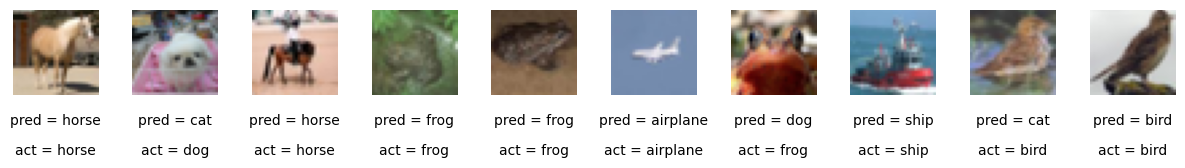

In [53]:
N_IMAGES = 10
indices = np.random.choice(range(len(x_test)), N_IMAGES)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, N_IMAGES, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + str(y_pred_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + str(y_test_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)